In [12]:
# %%writefile tem_ip.py
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
import matplotlib 
from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
from simpegEMIP.Base import BaseEMIPProblem
matplotlib.rcParams["font.size"] = 14

# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 0.5
wiresEM = Maps.Wires(('sigmaInf', mesh.nC), ('eta', mesh.nC), ('tau', mesh.nC), ('c', mesh.nC))
m = np.r_[sigmaInf, eta, tau, c]
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
# prb_emip.verbose = True
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey)
F = prb_emip.fields([])
data = survey.dpred([], f=F)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [13]:
# !python tem_ip.py

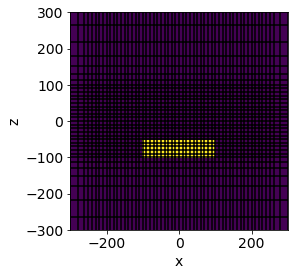

In [14]:
mesh.plotImage(eta, grid=True, mirror=True)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.gca().set_aspect('equal')

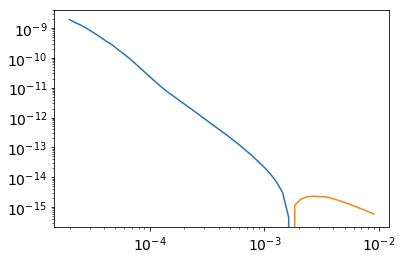

In [15]:
plt.loglog(rx.times, -data)
plt.loglog(rx.times, data)

In [16]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
t0 = 1.47e-3
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=t0), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = Problem3D_e(mesh, sigmaInfMap=wiresEM.sigmaInf, etaMap=wiresEM.eta, tauMap=wiresEM.tau, cMap=wiresEM.c)
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(t0/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(m)
data_ramp = survey_ramp.dpred(m, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

(-0.2, 1.2)

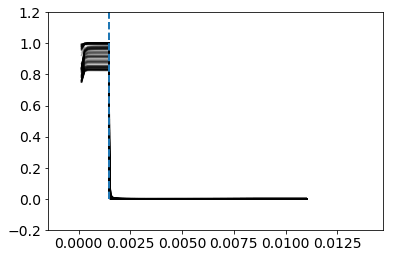

In [17]:
z = mesh.vectorCCz[np.logical_and(mesh.vectorCCz < 0., mesh.vectorCCz > -200.)]
x = mesh.vectorCCx[mesh.vectorCCx < 100.]
xyz = Utils.ndgrid(x, np.r_[0.], z)
e_ramp = F_ramp[src_ramp,'eSolution', :]
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em_ramp.times[1:], e_ramp[rxind,1:].flatten() / e_ramp[rxind,1:].max(), 'k', alpha=0.2)
# plt.xscale('log')
plt.plot(np.ones(2)*t0, np.r_[0, 1.2], '--', lw=2)
plt.xlim(-t0, t0*10)
plt.ylim(-0.2, 1.2)

In [18]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
t0 = 4.2e-3
tpeak = 2.73e-3
rx_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, 'z')
src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
survey_vtem = EM.TDEM.Survey([src_vtem])
prb_em_vtem = Problem3D_e(mesh, sigmaInfMap=wiresEM.sigmaInf, etaMap=wiresEM.eta, tauMap=wiresEM.tau, cMap=wiresEM.c)
# prb_em_vtem.verbose = True
prb_em_vtem.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_vtem.Solver = PardisoSolver
prb_em_vtem.pair(survey_vtem)
F_vtem = prb_em_vtem.fields(m)
data_vtem = survey_vtem.dpred(m, f=F_vtem)
cur = []
for t in prb_em_vtem.times:
    cur.append(src_vtem.waveform.eval(t))
cur = np.hstack(cur)


(0.0, 0.01)

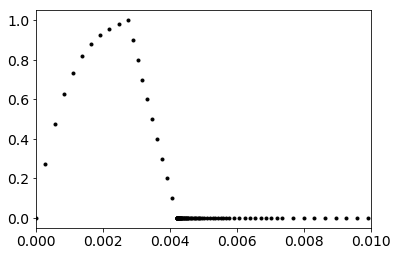

In [19]:
plt.plot(prb_em_vtem.times, cur, 'k.')
plt.xscale("linear")
plt.xlim(0., 1e-2)

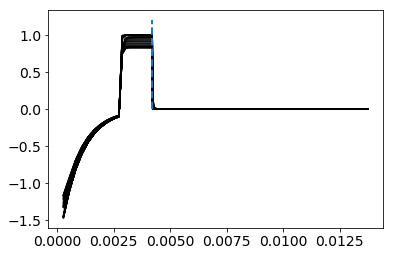

In [20]:
e_vtem = F_vtem[src_vtem,'eSolution', :]
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em_vtem.times[1:], e_vtem[rxind,1:].flatten() / e_vtem[rxind,1:].max(), 'k', alpha=0.2)
# plt.xscale('log')
plt.plot(np.ones(2)*t0, np.r_[0, 1.2], '--', lw=2)
# plt.xlim(tpeak, 1e-2)
# plt.ylim(-0.2, 1.2)


In [21]:
data_em = np.load("dataem.npy")
data_em_ramp = np.load("dataem_ramp.npy")
data_em_vtem = np.load("dataem_vtem.npy")
ip = data - data_em
ip_ramp = data_ramp - data_em_ramp
ip_vtem = data_vtem - data_em_vtem

In [22]:
np.save('data', data)
np.save('data_ramp', data_ramp)
np.save('data_vtem', data_vtem)

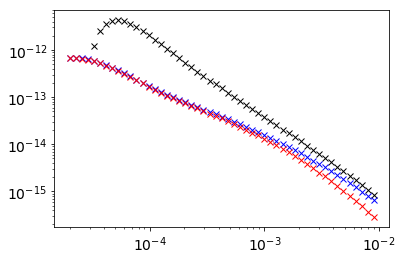

In [24]:
# plt.loglog(rx.times, -data, 'k.')
# plt.loglog(rx.times, data, 'k--')
# plt.loglog(rx.times, -data_em, 'k-')
# plt.loglog(rx.times, -data_ramp, 'b.')
# plt.loglog(rx.times, data_ramp, 'b--')
# plt.loglog(rx.times, -data_em_ramp, 'b-')
# plt.loglog(rx.times, -data_vtem, 'r.')
# plt.loglog(rx.times, data_vtem, 'r--')
# plt.loglog(rx.times, -data_em_vtem, 'r-')
plt.loglog(rx.times, ip, 'kx')
plt.loglog(rx.times, ip_ramp, 'bx')
plt.loglog(rx.times, ip_vtem, 'rx')


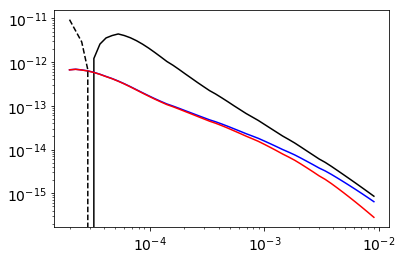

In [25]:
plt.loglog(rx.times, ip, 'k')
plt.loglog(rx.times, ip_ramp, 'b')
plt.loglog(rx.times, ip_vtem, 'r')
plt.loglog(rx.times, -ip, 'k--')
plt.loglog(rx.times, -ip_ramp, 'b--')
plt.loglog(rx.times, -ip_vtem, 'r--')

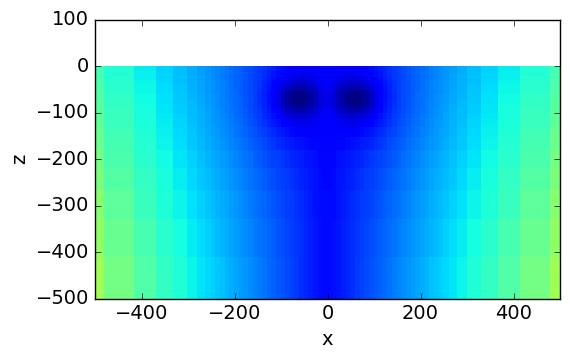

In [16]:
temp = mesh.aveE2CC*e_vtem[:,70]
temp[airind] = np.nan
mesh.plotImage(temp, mirror=True, clim =(temp[~airind].min(), temp[~airind].max()) )
plt.xlim(-500, 500)
plt.ylim(-500, 100)
plt.gca().set_aspect('equal')

In [4]:
import numpy as np

In [5]:

out = ( np.arange(10)* np.ones((10, 1)))

In [6]:
out

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])